# Sentiment Classification of Movie Reviews (using Naive Bayes, Logistic Regression, and Ngrams)

The purpose of this notebook is to cover Naive Bayes, Logistic regression, and ngrams (some pretty classic techniques!) for sentiment classification.  We will be using sklearn and the fastai library.

In a future lesson, we will tackle this same problem of sentiment classification using deep learning, so that you can compare the two approaches

The content here was extended from [Lesson 10 of the fast.ai Machine Learning course](https://course.fast.ai/lessonsml1/lesson10.html). Linear model is pretty close to the state of the art here.  Jeremy surpassed state of the art using a RNN in fall 2017.

## 0.The fastai library

We will begin using [the fastai library](https://docs.fast.ai) (version 1.0) in this notebook.  We will use it more once we move on to neural networks.

The fastai library is built on top of PyTorch and encodes many state-of-the-art best practices. It is used in production at a number of companies.  You can read more about it here:

- [Fast.ai's software could radically democratize AI](https://www.zdnet.com/article/fast-ais-new-software-could-radically-democratize-ai/) (ZDNet)

- [fastai v1 for PyTorch: Fast and accurate neural nets using modern best practices](https://www.fast.ai/2018/10/02/fastai-ai/) (fast.ai)

- [fastai docs](https://docs.fast.ai/)

### Installation

With conda:

`conda install -c pytorch -c fastai fastai=1.0`

Or with pip:

`pip install fastai==1.0`

More [installation information here](https://github.com/fastai/fastai/blob/master/README.md).

Beginning in lesson 4, we will be using GPUs, so if you want, you could switch to a [cloud option](https://course.fast.ai/#using-a-gpu) now to setup fastai.

## 1. The IMDB dataset

The [large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) contains a collection of 50,000 reviews from IMDB, We will use the version hosted as part [fast.ai datasets](https://course.fast.ai/datasets.html) on AWS Open Datasets. 

The dataset contains an even number of positive and negative reviews. The authors considered only highly polarized reviews. A negative review has a score ≤ 4 out of 10, and a positive review has a score ≥ 7 out of 10. Neutral reviews are not included in the dataset. The dataset is divided into training and test sets. The training set is the same 25,000 labeled reviews.

The **sentiment classification task** consists of predicting the polarity (positive or negative) of a given text.

### Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from fastai.utils.mem import GPUMemTrace #call with mtrace

In [3]:
import sklearn.feature_extraction.text as sklearn_text

### Preview the sample IMDb data set

fast.ai has a number of [datasets hosted via AWS Open Datasets](https://course.fast.ai/datasets.html) for easy download. We can see them by checking the docs for URLs (remember `??` is a helpful command):

In [4]:
?? URLs

It is always good to start working on a sample of your data before you use the full dataset-- this allows for quicker computations as you debug and get your code working. For IMDB, there is a sample dataset already available:

In [5]:
path = untar_data(URLs.IMDB_SAMPLE)
path

WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb_sample')

#### Read the data set into a pandas dataframe, which we can inspect to get a sense of what our data looks like. We see that the three columns contain review label, review text, and the `is_valid` flag, respectively. `is_valid` is a boolean flag indicating whether the row is from the validation set or not.

In [6]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


### Extract the movie reviews from the sample IMDb data set.
#### We will be using [TextList](https://docs.fast.ai/text.data.html#TextList) from the fastai library:

In [7]:
%%time
# throws `BrokenProcessPool' Error sometimes. Keep trying `till it works!

count = 0
error = True
while error:
    try: 
        # Preprocessing steps
        movie_reviews = (TextList.from_csv(path, 'texts.csv', cols='text')
                         .split_from_df(col=2)
                         .label_from_df(cols=0))
        error = False
        print(f'failure count is {count}\n')    
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')


failure count is 3

Wall time: 1min 43s


### Exploring IMDb review data

A good first step for any data problem is to explore the data and get a sense of what it looks like.  In this case we are looking at movie reviews, which have been labeled as "positive" or "negative". The reviews have already been `tokenized`, i.e. split into `tokens`, basic units such as words, prefixes, punctuation, capitalization, and other features of the text.

In [8]:
movie_reviews

LabelLists;

Train: LabelList (800 items)
x: TextList
xxbos xxmaj un - xxunk - believable ! xxmaj meg xxmaj ryan does n't even look her usual xxunk lovable self in this , which normally makes me forgive her shallow xxunk acting xxunk . xxmaj hard to believe she was the producer on this dog . xxmaj plus xxmaj kevin xxmaj kline : what kind of suicide trip has his career been on ? xxmaj xxunk ... xxmaj xxunk ! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a replay of xxmaj jonestown - hollywood style . xxmaj xxunk !,xxbos xxmaj this is a extremely well - made film . xxmaj the acting , script and camera - work are all first - rate . xxmaj the music is good , too , though it is mostly early in the film , when things are still relatively xxunk . xxmaj there are no really xxunk in the cast , though several faces will be familiar . xxmaj the entire cast does an excellent job with the script . 
 
  xxmaj but it is hard to watch , because there is n

### Let's examine the`movie_reviews` object:

In [9]:
dir(movie_reviews)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'add_test',
 'add_test_folder',
 'databunch',
 'filter_by_func',
 'get_processors',
 'label_const',
 'label_empty',
 'label_from_df',
 'label_from_folder',
 'label_from_func',
 'label_from_list',
 'label_from_lists',
 'label_from_re',
 'lists',
 'load_empty',
 'load_state',
 'path',
 'process',
 'test',
 'train',
 'transform',
 'transform_y',
 'valid']

### movie_reviews splits the data into training and validation sets, .train and .valid 

In [10]:
print(f'There are {len(movie_reviews.train.x)} and {len(movie_reviews.valid.x)} reviews in the training and validations sets, respectively.')

There are 800 and 200 reviews in the training and validations sets, respectively.


### Reviews are composed of lists of tokens. In NLP, a **token** is the basic unit of processing (what the tokens are depends on the application and your choices). Here, the tokens mostly correspond to words or punctuation, as well as several special tokens, corresponding to unknown words, capitalization, etc.

### Special tokens:
All those tokens starting with "xx" are fastai special tokens.  You can see the list of all of them and their meanings ([in the fastai docs](https://docs.fast.ai/text.transform.html)): 

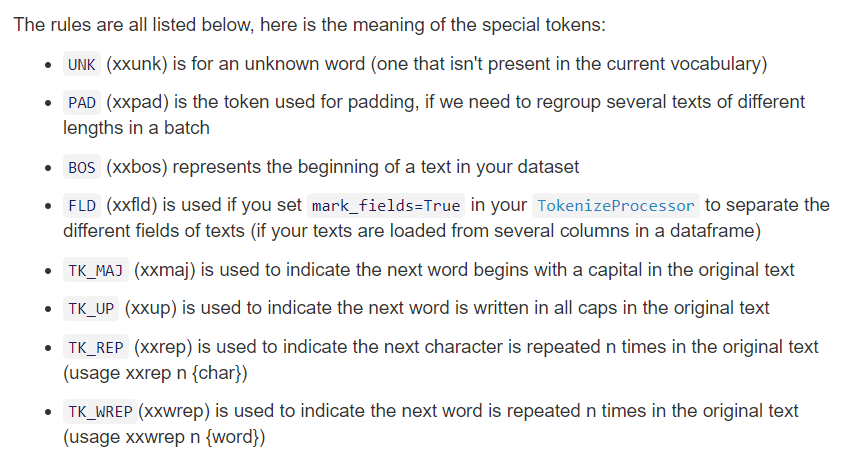

### Let's examine the structure of the training set

#### movie_reviews.train is a `LabelList` object. 
#### movie_reviews.train.x  is a `TextList` object that holds the reviews
#### movie_reviews.train.y is a `CategoryList` object that holds the labels 

In [11]:
print(f'\fThere are {len(movie_reviews.train.x)} movie reviews in the training set\n')
print(movie_reviews.train)

There are 800 movie reviews in the training set

LabelList (800 items)
x: TextList
xxbos xxmaj un - xxunk - believable ! xxmaj meg xxmaj ryan does n't even look her usual xxunk lovable self in this , which normally makes me forgive her shallow xxunk acting xxunk . xxmaj hard to believe she was the producer on this dog . xxmaj plus xxmaj kevin xxmaj kline : what kind of suicide trip has his career been on ? xxmaj xxunk ... xxmaj xxunk ! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a replay of xxmaj jonestown - hollywood style . xxmaj xxunk !,xxbos xxmaj this is a extremely well - made film . xxmaj the acting , script and camera - work are all first - rate . xxmaj the music is good , too , though it is mostly early in the film , when things are still relatively xxunk . xxmaj there are no really xxunk in the cast , though several faces will be familiar . xxmaj the entire cast does an excellent job with the script . 
 
  xxmaj but it is hard

#### The text of the movie review is stored as a string of characters which are the tokens separated by spaces. Here is the text of the first review:

In [12]:
print(movie_reviews.train.x[0].text)
print(f'\nThere are {len(movie_reviews.train.x[0].text)} characters in the review')

xxbos xxmaj un - xxunk - believable ! xxmaj meg xxmaj ryan does n't even look her usual xxunk lovable self in this , which normally makes me forgive her shallow xxunk acting xxunk . xxmaj hard to believe she was the producer on this dog . xxmaj plus xxmaj kevin xxmaj kline : what kind of suicide trip has his career been on ? xxmaj xxunk ... xxmaj xxunk ! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a replay of xxmaj jonestown - hollywood style . xxmaj xxunk !

There are 511 characters in the review


#### The text string can be split to get the list of tokens.

In [13]:
print(movie_reviews.train.x[0].text.split())
print(f'\nThe review has {len(movie_reviews.train.x[0].text.split())} tokens')

['xxbos', 'xxmaj', 'un', '-', 'xxunk', '-', 'believable', '!', 'xxmaj', 'meg', 'xxmaj', 'ryan', 'does', "n't", 'even', 'look', 'her', 'usual', 'xxunk', 'lovable', 'self', 'in', 'this', ',', 'which', 'normally', 'makes', 'me', 'forgive', 'her', 'shallow', 'xxunk', 'acting', 'xxunk', '.', 'xxmaj', 'hard', 'to', 'believe', 'she', 'was', 'the', 'producer', 'on', 'this', 'dog', '.', 'xxmaj', 'plus', 'xxmaj', 'kevin', 'xxmaj', 'kline', ':', 'what', 'kind', 'of', 'suicide', 'trip', 'has', 'his', 'career', 'been', 'on', '?', 'xxmaj', 'xxunk', '...', 'xxmaj', 'xxunk', '!', '!', '!', 'xxmaj', 'finally', 'this', 'was', 'directed', 'by', 'the', 'guy', 'who', 'did', 'xxmaj', 'big', 'xxmaj', 'xxunk', '?', 'xxmaj', 'must', 'be', 'a', 'replay', 'of', 'xxmaj', 'jonestown', '-', 'hollywood', 'style', '.', 'xxmaj', 'xxunk', '!']

The review has 103 tokens


#### The review tokens are `numericalized`, ie. mapped to integers.  So a movie review is also stored as an array of integers:

In [14]:
print(movie_reviews.train.x[0].data)
print(f'\nThe array contains {len(movie_reviews.train.x[0].data)} numericalized tokens')

[   2    5 4622   25 ...   10    5    0   52]

The array contains 103 numericalized tokens


## 2. The IMDb Vocabulary

### The `movie_revews` object also contains a `.vocab` property, even though it is not shown with`dir()`. (This may be an error in the `fastai` library.) 

In [15]:
movie_reviews.vocab

### The `vocab` object is a kind of reversible dictionary that translates back and forth between tokens and their integer representations.  It has two methods of particular interest: `stoi` and `itos`, which stand for `string-to-index` and `index-to-string`

#### `movie_reviews.vocab.stoi` maps vocabulary tokens to their `indexes` in vocab

In [16]:
movie_reviews.vocab.stoi

defaultdict(int,
            {'xxunk': 0,
             'xxpad': 1,
             'xxbos': 2,
             'xxeos': 3,
             'xxfld': 4,
             'xxmaj': 5,
             'xxup': 6,
             'xxrep': 7,
             'xxwrep': 8,
             'the': 9,
             '.': 10,
             ',': 11,
             'and': 12,
             'a': 13,
             'of': 14,
             'to': 15,
             'is': 16,
             'it': 17,
             'in': 18,
             'i': 19,
             'that': 20,
             'this': 21,
             '"': 22,
             "'s": 23,
             '\n \n ': 24,
             '-': 25,
             'was': 26,
             'as': 27,
             'for': 28,
             'movie': 29,
             'with': 30,
             'but': 31,
             'film': 32,
             'you': 33,
             ')': 34,
             'on': 35,
             '(': 36,
             "n't": 37,
             'are': 38,
             'he': 39,
             'his': 40,
       

#### `movie_reviews.vocab.itos` maps the `indexes` of vocabulary tokens to `strings`

In [17]:
movie_reviews.vocab.itos

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 '.',
 ',',
 'and',
 'a',
 'of',
 'to',
 'is',
 'it',
 'in',
 'i',
 'that',
 'this',
 '"',
 "'s",
 '\n \n ',
 '-',
 'was',
 'as',
 'for',
 'movie',
 'with',
 'but',
 'film',
 'you',
 ')',
 'on',
 '(',
 "n't",
 'are',
 'he',
 'his',
 'not',
 'have',
 'be',
 'one',
 'they',
 'all',
 'at',
 'by',
 'an',
 'from',
 'like',
 '!',
 'so',
 'who',
 'there',
 'about',
 'just',
 'out',
 'if',
 'or',
 'do',
 'what',
 'her',
 'has',
 "'",
 'some',
 'more',
 'good',
 'when',
 'up',
 'very',
 '?',
 'she',
 'would',
 'no',
 'really',
 'were',
 'their',
 'my',
 'had',
 'time',
 'can',
 'only',
 'which',
 'even',
 'see',
 'story',
 'me',
 'into',
 'did',
 ':',
 'well',
 'we',
 'will',
 'does',
 'than',
 'also',
 'get',
 '...',
 'people',
 'other',
 'bad',
 'been',
 'could',
 'first',
 'much',
 'how',
 'most',
 'any',
 'because',
 'two',
 'then',
 'great',
 'him',
 'its',
 'too',
 'made',
 'them',
 'after',


#### Notice that ints-to-string and string-to-ints have different lengths.  Think for a moment about why this is. (See Hint below)

In [18]:
print('itos ', 'length ',len(movie_reviews.vocab.itos),type(movie_reviews.vocab.itos) )
print('stoi ', 'length ',len(movie_reviews.vocab.stoi),type(movie_reviews.vocab.stoi) )

itos  length  6016 <class 'list'>
stoi  length  19160 <class 'collections.defaultdict'>


#### Hint: `stoi` is an instance of the class `defaultdict`
<img src="default_dict.png" alt="floating point" style="width: 90%"/>

#### In a `defaultdict`, rare words that appear fewer than three times in the corpus, and words that are not in the dictionary, are mapped to a `default value`, in this case, zero

In [19]:
rare_words = ['acrid','a_random_made_up_nonexistant_word','acrimonious','allosteric','anodyne','antikythera']
for word in rare_words:
    print(movie_reviews.vocab.stoi[word])

0
0
0
0
0
0


#### What's the `token` corresponding to the `default` value?

In [20]:
print(movie_reviews.vocab.itos[0])

xxunk


#### Note that `stoi` (string-to-int) is larger than `itos` (int-to-string).

In [21]:
print(len(movie_reviews.vocab.stoi))
print(len(movie_reviews.vocab.itos))
print(len(movie_reviews.vocab.stoi) - len(movie_reviews.vocab.itos))

19165
6016
13149


#### This is because many words are mapping to unknown.  We can confirm here:

In [22]:
unk = []
for word, num in movie_reviews.vocab.stoi.items():
    if num==0:
        unk.append(word)

In [23]:
len(unk)

13155

#### Here are the first 100 words that are mapped to 'unknown'

In [24]:
unk[:100]

['xxunk',
 'bleeping',
 'pert',
 'ticky',
 'schtick',
 'whoosh',
 'banzai',
 'chill',
 'wooofff',
 'cheery',
 'superstars',
 'fashionable',
 'cruelly',
 'separating',
 'mistreat',
 'tensions',
 'religions',
 'baseness',
 'nobility',
 'puro',
 'disowned',
 'option',
 'faults',
 'dignified',
 'realisation',
 'reconciliation',
 'mrs',
 'iyer',
 'heartbreaking',
 'histories',
 'frankness',
 'starters',
 'montage',
 'swearing',
 'halestorm',
 'korea',
 'concentrate',
 'pic',
 'elude',
 'characteristics',
 'blathered',
 'brassed',
 'declaration',
 'peck',
 'garnered',
 'fearless',
 'tempered',
 'humane',
 'tails',
 'slighted',
 'slater',
 'barrage',
 'underway',
 'operating',
 'tag',
 'dorff',
 'reid',
 'continually',
 'revel',
 'nra',
 'benton',
 'slate',
 'penal',
 'vengeful',
 'seed',
 'backbone',
 'dismal',
 'fortunate',
 'ds',
 'tmob',
 'autographed',
 'intercepted',
 'lectured',
 'reprints',
 'comicon',
 'attendees',
 'blackhawk',
 'insisted',
 'jumped',
 'apologized',
 'wishing',
 'se

## 3. Map the movie reviews into a vector space

### There are 6016 unique tokens in the IMDb review vocabulary. Their numericalized values range from 0 to 6015

In [25]:
print(f'There are {len(movie_reviews.vocab.itos)} unique tokens in the IMDb review sample vocabulary')
print(f'The numericalized token values run from {min(movie_reviews.vocab.stoi.values())} to {max(movie_reviews.vocab.stoi.values())} ')

There are 6016 unique tokens in the IMDb review sample vocabulary
The numericalized token values run from 0 to 6015 


### Each review can be mapped to a 6016-dimensional `embedding vector` whose indices correspond to the numericalized tokens, and whose values are the number of times the corresponding token appeared in the review. To do this efficiently we need to learn a bit about `Counters`.

### 3A. Counters

A **Counter** is a useful Python object.  A **Counter** applied to a list returns an ordered dictionary whose keys are the unique elements in the list, and whose values are the counts of the unique elements. Counters are from the collections module (along with OrderedDict, defaultdict, deque, and namedtuple).
Here is how Counters work:

#### Let's make a TokenCounter for movie reviews

In [26]:
TokenCounter = lambda review_index :Counter((movie_reviews.train.x)[review_index].data)
TokenCounter(0).items()

dict_items([(2, 1), (5, 15), (4622, 1), (25, 3), (0, 8), (867, 1), (52, 5), (3776, 1), (1800, 1), (95, 1), (37, 1), (85, 1), (191, 1), (63, 2), (936, 1), (2740, 1), (517, 1), (18, 1), (21, 3), (11, 1), (84, 1), (2418, 1), (192, 1), (88, 1), (3777, 1), (1801, 1), (127, 1), (10, 3), (269, 1), (15, 1), (273, 1), (73, 1), (26, 2), (9, 2), (1360, 1), (35, 2), (1213, 1), (1144, 1), (1145, 1), (2419, 1), (91, 1), (62, 1), (245, 1), (14, 2), (1361, 1), (1447, 1), (64, 1), (40, 1), (797, 1), (103, 1), (72, 2), (99, 1), (534, 1), (616, 1), (48, 1), (282, 1), (54, 1), (90, 1), (219, 1), (228, 1), (43, 1), (13, 1), (3778, 1), (3779, 1), (355, 1), (492, 1)])

#### The TokenCounter `keys` are the numericalized `tokens` that apper in the review

In [27]:
TokenCounter(0).keys()

dict_keys([2, 5, 4622, 25, 0, 867, 52, 3776, 1800, 95, 37, 85, 191, 63, 936, 2740, 517, 18, 21, 11, 84, 2418, 192, 88, 3777, 1801, 127, 10, 269, 15, 273, 73, 26, 9, 1360, 35, 1213, 1144, 1145, 2419, 91, 62, 245, 14, 1361, 1447, 64, 40, 797, 103, 72, 99, 534, 616, 48, 282, 54, 90, 219, 228, 43, 13, 3778, 3779, 355, 492])

#### The TokenCounter `values` are the `token multiplicities`, i.e the number of times each `token` appears in the review

In [28]:
TokenCounter(0).values()

dict_values([1, 15, 1, 3, 8, 1, 5, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### 3B. CountVectorizer

#### Make a `count_vectorizer` function that maps a review to a 6016-dimensional `embedding vector`
#### The `indices` of  the `embedding vector` correspond to the numericalized tokens in the vocabulary; the `values` specify how often the corresponding token appears in the review. 

In [29]:
n_terms = len(movie_reviews.vocab.itos)
n_docs = len(movie_reviews.train.x)
make_token_counter = lambda review_index: Counter(movie_reviews.train.x[review_index].data)
def count_vectorizer(review_index,make_token_counter = make_token_counter):
    review_vector = np.zeros(n_terms)
    for _, item in enumerate(make_token_counter(review_index).items()):
        review_vector[item[0]] = item[1]
    return review_vector

# make the embedding vector for the first review
review_vector = count_vectorizer(0)
print(review_vector)
print(f'The review is embedded in a {len(review_vector)} dimensional vector')


[8. 0. 1. 0. ... 0. 0. 0. 0.]
The review is embedded in a 6016 dimensional vector


#### Here is the embedding vector for the first review in the training data set

In [30]:
review_vector

array([8., 0., 1., 0., ..., 0., 0., 0., 0.])

## 4. Create the document-term matrix for the IMDb

#### In non-deep learning methods of NLP, we are often interested only in `which words` were used in a review, and `how often each word got used`. This is known as the `bag of words` approach, and it suggests a really simple way to store a document (in this case, a movie review). 

#### For each review we can keep track of which words were used and how often each word was used with a `vector` whose `length` is the number of tokens in the vocabulary, which we will call `n`. The `indexes` of this `vector` correspond to the `tokens` in the `IMDb vocabulary`, and the`values` of the vector are the number of times the corresponding tokens appeared in the review. For example the values stored at indexes 0, 1, 2, 3, 4 of the vector record the number of times the 5 tokens ['xxunk','xxpad','xxbos','xxeos','xxfld'] appeared in the review, respectively.

#### Now, if our movie review database has `m` reviews, and each review is represented by a `vector` of length `n`, then vertically stacking the row vectors for all the reviews creates a matrix representation of the IMDb, which we call its `document-term matrix`. The `rows` correspond to `documents` (reviews), while the `columns` correspond to `terms` (or tokens in the vocabulary).

In the previous lesson, we used [sklearn's CountVectorizer](https://github.com/scikit-learn/scikit-learn/blob/55bf5d9/sklearn/feature_extraction/text.py#L940) to generate the `vectors` that represent individual reviews. Today we will create our own (similar) version.  This is for two reasons:
- to understand what sklearn is doing underneath the hood
- to create something that will work with a fastai TextList

### Form the embedding vectors for the movie_reviews training set and stack them vertically

In [31]:
# Define a function to build the full document-term matrix
print(f'there are {n_docs} reviews, and {n_terms} unique tokens in the vocabulary')
def make_full_doc_term_matrix(count_vectorizer,n_terms,n_docs):
    # for each movie review
    for doc_index in range(n_docs):
        review_vector = np.zeros(n_terms)
        # populate the embedding vector for this review
        for _, item in enumerate(TokenCounter(doc_index).items()):
            review_vector[item[0]] = item[1]
        # append the embedding vector to the document-term matrix
        if(doc_index == 0):
            A = review_vector
        else:
            A = np.vstack((A,review_vector))
    # return the document-term matrix
    return A

# Build the full document term matrix for the movie_reviews training set
A = make_full_doc_term_matrix(count_vectorizer,n_terms,n_docs)

there are 800 reviews, and 6016 unique tokens in the vocabulary


### Explore the `sparsity` of the document-term matrix

#### The `sparsity` of a matrix is defined as the fraction of of zero-valued elements

In [32]:
NNZ = np.count_nonzero(A)
sparsity = (A.size-NNZ)/A.size
print(f'Only {NNZ} of the {A.size} elements in the document-term matrix are nonzero')
print(f'The sparsity of the document-term matrix is {sparsity}')

Only 112413 of the 4812800 elements in the document-term matrix are nonzero
The sparsity of the document-term matrix is 0.9766429105718085


#### Using matplotlib's `spy` method, we can visualize the structure of the `document-term matrix`
`spy` plots the array with a mark indicating each non-zero value. This takes a few minutes.

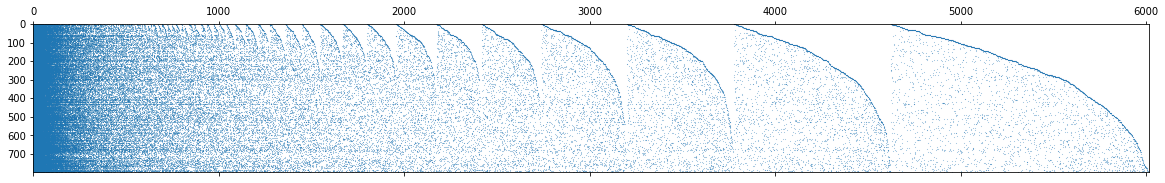

In [34]:
fig = plt.figure()
plt.spy(A, markersize=0.10)
fig.set_size_inches(20,20)
fig.savefig('doc_term_matrix.png', dpi=800)
# <img src="doc_term_matrix.png" alt="floating point" style="width: 90%"/>

#### Evidently, the document-term matrix is `sparse` ie. has a high proportion of zeros! To exploit this sparsity, we first need to learn a bit more about `sparse matrices`

## 5. Sparse Matrices

#### Even though we've reduced over 19,000 unique words in our corpus of reviews down to a vocabulary of 6,000 words, that's still a lot! But reviews are generally short, a few hundred words. So most tokens don't appear in a typical review.  That means that most of the entries in the document-term matrix will be zeros, and therefore ordinary matrix operations will waste a lot of compute resources multiplying and adding zeros. 

####  We want to maximize the use of space and time by storing and performing matrix operations on our document-term matrix as a **sparse matrix**. `scipy` provides tools for efficient sparse matrix representatin and operations. 

#### Loosely speaking,  matrix with a high proportion of zeros is called `sparse` (the opposite of sparse is `dense`).  For sparse matrices, you can save a lot of memory by only storing the non-zero values.

#### More specifically, a class of matrices is called **sparse** if the number of non-zero elements is proportional to the number of rows (or columns) instead of being proportional to the product rows x columns. An example is the class of diagonal matrices.


<img src="images/sparse.png" alt="floating point" style="width: 30%"/>



### Visualizing sparse matrix structure
<img src="sparse-matrix-structure-visualization.png" alt="floating point" style="width: 90%"/>
ref. https://scipy-lectures.org/advanced/scipy_sparse/introduction.html

### Sparse matrix storage formats

<img src="summary_of_sparse_matrix_storage_schemes.png" alt="floating point" style="width: 90%"/>
ref. https://scipy-lectures.org/advanced/scipy_sparse/storage_schemes.html

There are the most common sparse storage formats:
- coordinate-wise (scipy calls COO)
- compressed sparse row (CSR)
- compressed sparse column (CSC)



### Examples of the Compressed Sparse Row (CSR) format

Before we walk through the examples in the Emory University website, let's start out with a proper definition of the **CSR format** (ref. https://en.wikipedia.org/wiki/Sparse_matrix)

Given a full matrix **`A`** that has **`m`** rows, **`n`** columns, and **`N`** nonzero values, the CSR (Compressed Sparse Row) representation is stored using three arrays as follows:

**`Val[0:N]`** contains the **values** of the **`N` non-zero elements**.

**`Col[0:N]`** contains the **column indices** of the **`N` non-zero elements**. 
    
For each row **`i`** of **`A`**, **`RowPointer[i]`** contains the index in **Col** of the the first **nonzero value** in row **`i`**. If there are no nonzero values in the **ith** row, then **`RowPointer[i]` = 0**. And, by convention, an extra value **`RowPointer[m]` = N** is tacked on at the end. 

Question: How many floats and ints does it take to store the matrix **`A`** in CSR format?

Let's walk through [these examples](http://www.mathcs.emory.edu/~cheung/Courses/561/Syllabus/3-C/sparse.html)



## 6. Store the document-term matrix in CSR format
i.e. given the TextList object containing the list of reviews, return the three arrays (values, column_indices, row_pointer)

### Scipy Implementation of sparse matrices

From the [Scipy Sparse Matrix Documentation](https://docs.scipy.org/doc/scipy-0.18.1/reference/sparse.html)

- To construct a matrix efficiently, use either dok_matrix or lil_matrix. The lil_matrix class supports basic slicing and fancy indexing with a similar syntax to NumPy arrays. As illustrated below, the COO format may also be used to efficiently construct matrices
- To perform manipulations such as multiplication or inversion, first convert the matrix to either CSC or CSR format.
- All conversions among the CSR, CSC, and COO formats are efficient, linear-time operations.

### To really understand the CSR format, we need to be able know these how to do these two things:
1. Translate a regular matrix A into CSR format
2. Reconstruct a regular matrix from its CSR sparse representation


### 6.1. Translate a regular matrix A into CSR format

In [35]:
# construct the document-term matrix in CSR format
# i.e. return (values, column_indices, row_pointer)
def get_doc_term_matrix(text_list, n_terms):
    
    # inputs:
    #    text_list, a TextList object
    #    n_terms, the number of tokens in our IMDb vocabulary
    
    # output: 
    #    the CSR format sparse representation of the document-term matrix in the form of a
    #    scipy.sparse.csr.csr_matrix object

    
    # initialize arrays
    values = []
    column_indices = []
    row_pointer = []
    row_pointer.append(0)

    # from the TextList object
    for _, doc in enumerate(text_list):
        feature_counter = Counter(doc.data)
        column_indices.extend(feature_counter.keys())
        values.extend(feature_counter.values())
        # Tack on N (number of nonzero elements in the matrix) to the end of the row_pointer array
        row_pointer.append(len(column_indices))
        
    return scipy.sparse.csr_matrix((values, column_indices, row_pointer),
                                   shape=(len(row_pointer) - 1, n_terms),
                                   dtype=int)

#### Get the document-term matrix in CSR format for the training data

In [38]:
%%time
trn_doc_term = get_doc_term_matrix(movie_reviews.train.x, len(movie_reviews.vocab.itos))

Wall time: 270 ms


In [39]:
type(trn_doc_term)

scipy.sparse.csr.csr_matrix

In [40]:
trn_doc_term.shape

(800, 6016)

#### Get the document-term matrix in CSR format for the validation data

In [41]:
%%time
val_doc_term = get_doc_term_matrix(movie_reviews.valid.x, len(movie_reviews.vocab.itos))

Wall time: 45.4 ms


In [42]:
type(val_doc_term)

scipy.sparse.csr.csr_matrix

In [43]:
val_doc_term.shape

(200, 6016)

### 6.2 Reconstruct a regualr matrix from its CSR sparse representation
TBD

## 7. IMDb data exploration exercises

#### We could convert our sparse matrix to a dense matrix:

In [44]:
val_doc_term.shape

(200, 6016)

In [45]:
val_doc_term

<200x6016 sparse matrix of type '<class 'numpy.int32'>'
	with 27848 stored elements in Compressed Sparse Row format>

In [46]:
val_doc_term.todense()[:10,:10]

matrix([[32,  0,  1,  0, ...,  1,  0,  0, 10],
        [ 9,  0,  1,  0, ...,  1,  0,  0,  7],
        [ 6,  0,  1,  0, ...,  0,  0,  0, 12],
        [78,  0,  1,  0, ...,  0,  0,  0, 44],
        ...,
        [ 8,  0,  1,  0, ...,  0,  0,  0,  8],
        [43,  0,  1,  0, ...,  8,  1,  0, 25],
        [ 7,  0,  1,  0, ...,  1,  0,  0,  9],
        [19,  0,  1,  0, ...,  2,  0,  0,  5]])

#### Consider the second review in the validation set

In [47]:
review = movie_reviews.valid.x[1]
review

Text xxbos i saw this movie once as a kid on the late - late show and fell in love with it . 
 
  xxmaj it took 30 + years , but i recently did find it on xxup dvd - it was n't cheap , either - in a xxunk that xxunk in war movies . xxmaj we watched it last night for the first time . xxmaj the audio was good , however it was grainy and had the trailers between xxunk . xxmaj even so , it was better than i remembered it . i was also impressed at how true it was to the play . 
 
  xxmaj the xxunk is around here xxunk . xxmaj if you 're xxunk in finding it , fire me a xxunk and i 'll see if i can get you the xxunk . xxunk

**Exercise 1:** How many times does the word "it" appear in this review? Confirm that the correct values is stored in the document-term matrix, for the row corresponding to this review and the column corresponding to the word "it".

#### Answer 1:

In [48]:
# try it! 
# Your code here.

**Exercise 2**: Confirm that the review has 144 tokens, 81 of which are distinct

#### Answer 2:

In [52]:
val_doc_term[1]

<1x6016 sparse matrix of type '<class 'numpy.int32'>'
	with 81 stored elements in Compressed Sparse Row format>

In [53]:
val_doc_term[1].sum()

144

**Exercise 3:** How could you convert review.data back to text (without just using review.text)?

In [54]:
review.data

array([  2,  19, 248,  21, ...,   9,   0,  10,   0], dtype=int64)

#### Answer 3:

In [54]:
word_list = [movie_reviews.vocab.itos[a] for a in review.data]
print(word_list)

['xxbos', 'i', 'saw', 'this', 'movie', 'once', 'as', 'a', 'kid', 'on', 'the', 'late', '-', 'late', 'show', 'and', 'fell', 'in', 'love', 'with', 'it', '.', '\n \n ', 'xxmaj', 'it', 'took', '30', '+', 'years', ',', 'but', 'i', 'recently', 'did', 'find', 'it', 'on', 'xxup', 'dvd', '-', 'it', 'was', "n't", 'cheap', ',', 'either', '-', 'in', 'a', 'xxunk', 'that', 'xxunk', 'in', 'war', 'movies', '.', 'xxmaj', 'we', 'watched', 'it', 'last', 'night', 'for', 'the', 'first', 'time', '.', 'xxmaj', 'the', 'audio', 'was', 'good', ',', 'however', 'it', 'was', 'grainy', 'and', 'had', 'the', 'trailers', 'between', 'xxunk', '.', 'xxmaj', 'even', 'so', ',', 'it', 'was', 'better', 'than', 'i', 'remembered', 'it', '.', 'i', 'was', 'also', 'impressed', 'at', 'how', 'true', 'it', 'was', 'to', 'the', 'play', '.', '\n \n ', 'xxmaj', 'the', 'xxunk', 'is', 'around', 'here', 'xxunk', '.', 'xxmaj', 'if', 'you', "'re", 'xxunk', 'in', 'finding', 'it', ',', 'fire', 'me', 'a', 'xxunk', 'and', 'i', "'ll", 'see', 'if',

In [56]:
reconstructed_text = ' '.join(word_list)
print(reconstructed_text)

xxbos i saw this movie once as a kid on the late - late show and fell in love with it . 
 
  xxmaj it took 30 + years , but i recently did find it on xxup dvd - it was n't cheap , either - in a xxunk that xxunk in war movies . xxmaj we watched it last night for the first time . xxmaj the audio was good , however it was grainy and had the trailers between xxunk . xxmaj even so , it was better than i remembered it . i was also impressed at how true it was to the play . 
 
  xxmaj the xxunk is around here xxunk . xxmaj if you 're xxunk in finding it , fire me a xxunk and i 'll see if i can get you the xxunk . xxunk


## *Video 4 material ends here.* 
## *Video 5 material begins below.*

## 8. Naive Bayes

**Exercise**: Confirm that the review has 81 distinct tokens

#### Answer

In [56]:
# Exercise
len(set(review.data))

81

#### Note that `stoi` (string-to-int) is larger than `itos` (int-to-string).

In [293]:
len(movie_reviews.vocab.stoi)

19167

In [294]:
len(movie_reviews.vocab.itos)

6016

In [292]:
len(movie_reviews.vocab.stoi) - len(movie_reviews.vocab.itos)

13151

#### This is because many words in the review corpus map to `unknown`.  We can confirm here:

In [59]:
unk = []
for word, num in movie_reviews.vocab.stoi.items():
    if num==0:
        unk.append(word)

In [60]:
len(unk)

13151

In [61]:
unk[:100]

['xxunk',
 'bleeping',
 'pert',
 'ticky',
 'schtick',
 'whoosh',
 'banzai',
 'chill',
 'wooofff',
 'cheery',
 'superstars',
 'fashionable',
 'cruelly',
 'separating',
 'mistreat',
 'tensions',
 'religions',
 'baseness',
 'nobility',
 'puro',
 'disowned',
 'option',
 'faults',
 'dignified',
 'realisation',
 'reconciliation',
 'mrs',
 'iyer',
 'heartbreaking',
 'histories',
 'frankness',
 'starters',
 'montage',
 'swearing',
 'halestorm',
 'korea',
 'concentrate',
 'pic',
 'elude',
 'characteristics',
 'blathered',
 'brassed',
 'declaration',
 'peck',
 'garnered',
 'fearless',
 'tempered',
 'humane',
 'tails',
 'slighted',
 'slater',
 'barrage',
 'underway',
 'operating',
 'tag',
 'dorff',
 'reid',
 'continually',
 'revel',
 'nra',
 'benton',
 'slate',
 'penal',
 'vengeful',
 'seed',
 'backbone',
 'dismal',
 'fortunate',
 'ds',
 'tmob',
 'autographed',
 'intercepted',
 'lectured',
 'reprints',
 'comicon',
 'attendees',
 'blackhawk',
 'insisted',
 'jumped',
 'apologized',
 'wishing',
 'se

We define the **log-count ratio** $r$ for each word $f$:

$r = \log \frac{\text{ratio of feature $f$ in positive documents}}{\text{ratio of feature $f$ in negative documents}}$

where ratio of feature $f$ in positive documents is the number of times a positive document has a feature divided by the number of positive documents.

#### vocabulary tokens 1000 to 1019

In [57]:
movie_reviews.vocab.itos[1000:1020]

['state',
 'street',
 'impossible',
 'clever',
 'development',
 'concept',
 'william',
 'worked',
 'adventure',
 'church',
 'unlike',
 'hold',
 'lots',
 'premise',
 'shooting',
 'washington',
 'sick',
 'effect',
 'waiting',
 'singing']

In [62]:
movie_reviews.y.classes

['negative', 'positive']

In [63]:
x = trn_doc_term
y = movie_reviews.train.y
val_y = movie_reviews.valid.y

In [64]:
positive = y.c2i['positive']
negative = y.c2i['negative']

In [65]:
np.squeeze(np.asarray(x[y.items==negative].sum(0)))

array([7153,    0,  417,    0, ...,    0,    0,    0,    0], dtype=int32)

In [66]:
np.asarray(x[y.items==positive].sum(0))

array([[6468,    0,  383,    0, ...,    0,    0,    0,    0]], dtype=int32)

In [67]:
np.squeeze(np.asarray(x[y.items==positive].sum(0)))

array([6468,    0,  383,    0, ...,    0,    0,    0,    0], dtype=int32)

The review has 81 distinct tokens in it, and 144 tokens total.

For each word in our vocabulary, we are summing up how many positive reviews it is in, and how many negative reviews.

In [54]:
review.data

array([  2,  19, 248,  21, ...,   9,   0,  10,   0], dtype=int64)

In [68]:
p1 = np.squeeze(np.asarray(x[y.items==positive].sum(0)))
p0 = np.squeeze(np.asarray(x[y.items==negative].sum(0)))

In [69]:
p1[:10]

array([ 6468,     0,   383,     0,     0, 10267,   674,    57,     0,  5260], dtype=int32)

In [70]:
len(p1), len(p0)

(6016, 6016)

In [71]:
v = movie_reviews.vocab

In [72]:
v.itos[0]

'xxunk'

### Using our ratios for even more data exploration

We can use p0 and p1 to do some more data exploration!

**Exercise**: compare how often "loved" appears in positive reviews vs. negative reviews.  How about "hate"?

#### Answer:

In [73]:
# Exercise: How often does the word "loved" appear in neg vs. pos reviews?


In [74]:
# Exercise: How often does the word "hated" appear in neg vs. pos reviews?


#### positive reviews with the word "hated"

I was curious to look at an example of a postive review with the word "hated" in it:

In [75]:
v.stoi['hated']

1977

In [76]:
a = np.argwhere((x[:,1977] > 0))[:,0]; a

array([ 15,  49, 304, 351, 393, 612, 695, 773])

In [77]:
b = np.argwhere(y.items==positive)[:,0]; b

array([  1,   3,  10,  11, ..., 787, 789, 790, 797], dtype=int64)

In [78]:
set(a).intersection(set(b))

{393, 612, 695}

In [79]:
review = movie_reviews.train.x[695]
review.text

"xxbos xxmaj xxunk , yeah this episode is extremely underrated . \n \n  xxmaj even though there is a xxup lot of bad writing and acting at parts . i think the good over wins the bad . \n \n  i love the xxunk parts and the big ' twist ' at the end . i absolutely love that scene when xxmaj michelle xxunk xxmaj tony . xxmaj it 's actually one of my favorite scenes of xxmaj season 1 . \n \n  xxmaj for some reason , people have always hated the xxmaj xxunk episodes , yet i have always liked them . xxmaj they 're not the best , in terms of writing . but the theme really does interest me , \n \n  i 'm gon na give it a xxup three star , but if the writing were a little more consistent i 'd give it xxup four ."

#### negative reviews with the word "loved"

Now, let's look at an example of a negative review that contains the word "loved"

In [80]:
v.stoi['loved']

535

In [81]:
a = np.argwhere((x[:,534] > 0))[:,0]; a

array([  0,  19,  24,  51,  61,  70,  81, 110, 123, 155, 175, 193, 221, 265, 274, 279, 284, 290, 295, 304, 360, 384,
       421, 465, 516, 520, 548, 569, 588, 604, 620, 631, 661, 672, 679, 702, 709, 759, 764, 792])

In [82]:
b = np.argwhere(y.items==negative)[:,0]; b

array([  0,   2,   4,   5, ..., 795, 796, 798, 799], dtype=int64)

In [83]:
set(a).intersection(set(b))

{0,
 24,
 51,
 70,
 81,
 123,
 155,
 193,
 221,
 274,
 279,
 284,
 290,
 295,
 304,
 421,
 516,
 548,
 604,
 620,
 631,
 672,
 679,
 709,
 759,
 764,
 792}

In [84]:
review = movie_reviews.train.x[792]
review.text

'xxbos xxmaj this is not really a zombie film , if we \'re xxunk zombies as the dead walking around . xxmaj here the protagonist , xxmaj xxunk xxmaj louque ( played by an xxunk young xxmaj dean xxmaj xxunk ) , xxunk control of a method to create zombies , though in fact , his \' method \' is to mentally project his thoughts and control other living people \'s minds turning them into xxunk slaves . xxmaj this is an interesting concept for a movie , and was done much more effectively by xxmaj xxunk xxmaj lang in his series of \' xxmaj dr. xxmaj mabuse \' films , including \' xxmaj dr. xxmaj mabuse the xxmaj xxunk \' ( xxunk ) and \' xxmaj the xxmaj testament of xxmaj dr. xxmaj mabuse \' ( 1933 ) . xxmaj here it is unfortunately xxunk to his quest to regain the love of his former fiancée , xxmaj claire xxmaj duvall ( played by the xxmaj anne xxmaj xxunk look alike with a bad xxunk , xxmaj dorothy xxmaj stone ) which is really the major theme . \n \n  xxmaj the movie has an intriguing begi

## 9. Applying Naive Bayes

In [85]:
p1 = np.squeeze(np.asarray(x[y.items==positive].sum(0)))
p0 = np.squeeze(np.asarray(x[y.items==negative].sum(0)))

In [86]:
pr1 = (p1+1) / ((y.items==positive).sum() + 1)
pr0 = (p0+1) / ((y.items==negative).sum() + 1)

In [87]:
r = np.log(pr1/pr0); r

array([-0.015811,  0.084839,  0.      ,  0.084839, ...,  0.084839,  0.084839,  0.084839,  0.084839])

### Vocab most likely associated with positive/negative reviews

In [88]:
biggest = np.argpartition(r, -10)[-10:]
smallest = np.argpartition(r, 10)[:10]

Most positive words:

In [89]:
[v.itos[k] for k in biggest]

['sport',
 'davies',
 'jabba',
 'jimmy',
 'felix',
 'gilliam',
 'noir',
 'astaire',
 'fanfan',
 'biko']

In [90]:
np.argmax(trn_doc_term[:,v.stoi['biko']])

515

In [91]:
movie_reviews.train.x[515]

Text xxbos " xxmaj the xxmaj true xxmaj story xxmaj of xxmaj the xxmaj friendship xxmaj that xxmaj shook xxmaj south xxmaj africa xxmaj and xxmaj xxunk xxmaj the xxmaj world . " 
 
  xxmaj richard xxmaj attenborough , who directed " a xxmaj bridge xxmaj too xxmaj far " and " xxmaj gandhi " , wanted to bring the story of xxmaj steve xxmaj biko to life , and the journey and trouble that xxunk xxmaj donald xxmaj woods went through in order to get his story told . xxmaj the films uses xxmaj wood 's two books for it 's information and basis - " xxmaj biko " and " xxmaj asking for xxmaj trouble " . 
 
  xxmaj the film takes place in the late 1970 's , in xxmaj south xxmaj africa . xxmaj south xxmaj africa is in the grip of the terrible apartheid , which keeps the blacks separated from the whites and xxunk the whites as the superior race . xxmaj the blacks are forced to live in xxunk on the xxunk of the cities and xxunk , and they come under frequent xxunk by the police and the army . xxmaj w

Most negative words:

In [92]:
[v.itos[k] for k in smallest]

['crater',
 'soderbergh',
 'crap',
 'porn',
 'disappointment',
 'vargas',
 'naschy',
 'dog',
 'worst',
 'fuqua']

In [93]:
np.argmax(trn_doc_term[:,v.stoi['soderbergh']])

434

In [94]:
movie_reviews.train.x[434]

Text xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of " xxmaj at xxmaj the xxmaj movies " in taking xxmaj steven xxmaj soderbergh to task . 
 
  xxmaj it 's usually satisfying to watch a film director change his style / subject , but xxmaj soderbergh 's most recent stinker , xxmaj the xxmaj girlfriend xxmaj xxunk ) , was also missing a story , so narrative ( and editing ? ) seem to suddenly be xxmaj soderbergh 's main challenge . xxmaj strange , after xxunk years in the business . xxmaj he was probably never much good at narrative , just xxunk it well inside " edgy " projects . 
 
  xxmaj none of this excuses him this present , almost diabolical failure . xxmaj as xxmaj david xxmaj xxunk xxunk , " two parts of xxmaj che do n't ( even ) make a whole " . 
 
  xxmaj epic xxunk in name only , xxmaj che(2008 ) barely qualifies as a feature film 

In [95]:
trn_doc_term[:,v.stoi['soderbergh']]

<800x1 sparse matrix of type '<class 'numpy.int32'>'
	with 1 stored elements in Compressed Sparse Row format>

In [96]:
[v.itos[k] for k in smallest]

['crater',
 'soderbergh',
 'crap',
 'porn',
 'disappointment',
 'vargas',
 'naschy',
 'dog',
 'worst',
 'fuqua']

### Continuing with Naive Bayes

In [97]:
(y.items==positive).mean(), (y.items==negative).mean()

(0.47875, 0.52125)

In [98]:
b = np.log((y.items==positive).mean() / (y.items==negative).mean())

In [99]:
preds = (val_doc_term @ r + b) > 0

In [100]:
(preds == val_y.items).mean()

0.645

## 10. Download and preprocess the `full IMDb data set`

Now that we have our approach working on a smaller sample of the data, we can try using it on the full dataset.

### Download data and process

In [101]:
path = untar_data(URLs.IMDB)
path.ls()

[WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/data_clas.pkl'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/data_lm.pkl'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/finetuned.pth'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/finetuned_enc.pth'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/imdb.vocab'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/ld.pkl'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/ll_clas.pkl'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/ll_lm.pkl'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/models'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/pretrained'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/README'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/test'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/tmp_clas'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/tmp_lm'),
 WindowsPath('C:/Users/cross-entropy/.fastai

In [102]:
(path/'train').ls()

[WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/train/labeledBow.feat'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/train/neg'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/train/pos'),
 WindowsPath('C:/Users/cross-entropy/.fastai/data/imdb/train/unsupBow.feat')]

In [103]:
??TextList.from_folder

### First part: Make a `TextList` object that is a list of `WindowsPath` objects, each of which contains the full path to one of the data files.

### Second part: Generate a `LabelLists` object that splits files by training and validation folders

### Third part: Create a `LabelLists` object which contains the data and its labels. This takes a few minutes. This is the origin of the problem: sometimes throws a `BrokenProcessPool` Error. Try until it works. We'll take some time to understand the structure of this object. Question: why does the progress bar come up twice, each time counting from 1 to 3?

## Original code: Attempt to split and label the data fails most of the time, throwing a `BrokenProcessPool`  error

In [105]:
%%time
# throws `BrokenProcessPool' Error sometimes. Keep trying `till it works!

count = 0
error = True
while error:
    try: 
        # Preprocessing steps
        reviews_full = (TextList.from_folder(path)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             # .label_from_folder in next line causes BrokenProcessPool error
             .label_from_folder(classes=['neg', 'pos']))
             #label them all with their folders
        error = False
        print(f'failure count is {count}\n')    
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')


failure count is 5

Wall time: 9min 28s


In [106]:
type(reviews_full)

fastai.data_block.LabelLists

In [107]:
type(reviews_full.valid.x)

fastai.text.data.TextList

In [108]:
# first review
reviews_full.valid.x[0]

Text xxbos xxmaj once again xxmaj mr. xxmaj costner has dragged out a movie for far longer than necessary . xxmaj aside from the terrific sea rescue sequences , of which there are very few i just did not care about any of the characters . xxmaj most of us have ghosts in the closet , and xxmaj costner 's character are realized early on , and then forgotten until much later , by which time i did not care . xxmaj the character we should really care about is a very cocky , overconfident xxmaj ashton xxmaj kutcher . xxmaj the problem is he comes off as kid who thinks he 's better than anyone else around him and shows no signs of a cluttered closet . xxmaj his only obstacle appears to be winning over xxmaj costner . xxmaj finally when we are well past the half way point of this stinker , xxmaj costner tells us all about xxmaj kutcher 's ghosts . xxmaj we are told why xxmaj kutcher is driven to be the best with no prior inkling or foreshadowing . xxmaj no magic here , it was all i could do to

In [109]:
type(reviews_full.valid.y)

fastai.data_block.CategoryList

In [110]:
# label of first review seems right
reviews_full.valid.y[0]

Category neg

In [111]:
dir(reviews_full.valid.y)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bunch',
 '_get_by_folder',
 '_label_cls',
 '_label_from_list',
 '_label_list',
 '_processor',
 '_relative_item_path',
 '_relative_item_paths',
 '_split',
 '_square_show',
 '_square_show_res',
 'add',
 'analyze_pred',
 'c',
 'c2i',
 'classes',
 'copy_new',
 'databunch',
 'filter_by_folder',
 'filter_by_func',
 'filter_by_rand',
 'filter_missing_y',
 'from_csv',
 'from_df',
 'from_folder',
 'get',
 'get_label_cls',
 'ignore_empty',
 'inner_df',
 'items',
 'label_cls',
 'label_const',
 'label_empty',
 'label_from_df',
 'label_from_folder',
 'label_from_func',
 'label_from_re',
 'loss_func',
 'ne

In [112]:
reviews_full.valid.y.classes

['neg', 'pos']

In [113]:
reviews_full.valid.y.c

2

In [114]:
reviews_full.valid.y.c2i

{'neg': 0, 'pos': 1}

In [115]:
type(reviews_full.valid.y[0])

fastai.core.Category

In [116]:
dir(reviews_full.valid.y[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'apply_tfms',
 'data',
 'obj',
 'show']

In [117]:
reviews_full.valid.y[0].data

0

In [118]:
reviews_full.valid.y[0].obj

'neg'

In [119]:
reviews_full.valid.y[0].show

<bound method ItemBase.show of Category neg>

In [120]:
[rr for rr in reviews_full.valid.y[::]][0:5]

[Category neg, Category neg, Category neg, Category neg, Category neg]

In [121]:
[rr for rr in reviews_full.valid.y[::-1]][0:5]

[Category pos, Category pos, Category pos, Category pos, Category pos]

### lengths of the training and validation data sets

In [122]:
len(reviews_full.train), len(reviews_full.valid)

(25000, 25000)

We will store the vocab in a variable `v` since we will be using it frequently:

In [123]:
v = reviews_full.vocab

In [124]:
v.itos[100:110]

['bad',
 'people',
 'will',
 'other',
 'also',
 'into',
 'first',
 'because',
 'great',
 'how']

### Create document-term matrices for training and validation sets. Despite the note below in the original notebook, this is actually pretty fast! ~4 sec per matrix

In [125]:
%%time
val_doc_term = get_doc_term_matrix(reviews_full.valid.x, len(reviews_full.vocab.itos))

Wall time: 3.56 s


In [126]:
%%time
trn_doc_term = get_doc_term_matrix(reviews_full.train.x, len(reviews_full.vocab.itos))

Wall time: 3.64 s


### Save data

That was slow.  Let's save our matrices for faster loading next time:

In [127]:
scipy.sparse.save_npz("trn_doc_term.npz", trn_doc_term)

In [128]:
scipy.sparse.save_npz("val_doc_term.npz", val_doc_term)

When storing data like this, always make sure it's included in your .gitignore file

In the future, we'll just be able to load our data:

In [129]:
trn_doc_term = scipy.sparse.load_npz("trn_doc_term.npz")
val_doc_term = scipy.sparse.load_npz("val_doc_term.npz")

## 11. Naive Bayes on full dataset

In [130]:
x=trn_doc_term
y=reviews_full.train.y
val_y = reviews_full.valid.y.items

In [131]:
x

<25000x38464 sparse matrix of type '<class 'numpy.int32'>'
	with 3716501 stored elements in Compressed Sparse Row format>

In [132]:
positive = y.c2i['pos']
negative = y.c2i['neg']

In [133]:
p0 = np.squeeze(np.asarray(x[y.items==negative].sum(0)))
p1 = np.squeeze(np.asarray(x[y.items==positive].sum(0)))

In [134]:
p0

array([26553,     0, 12500,     0, ...,     0,     0,     0,     0], dtype=int32)

In [135]:
p1

array([28399,     0, 12500,     0, ...,     0,     0,     0,     0], dtype=int32)

### Data exploration: negative to positive ratios

I was curious about the ratio of times a given word appears in negative reviews to times it occurs in positive reviews.  Bigger ratios (> 1) mean the word is indicative of a negative review, and smaller ratios (< 1) mean it is indicative of a positive review.

In [136]:
def neg_pos_given_word(word):
    print(p0[v.stoi[word]]/p1[v.stoi[word]])

In [137]:
neg_pos_given_word('hated')

2.051546391752577


In [138]:
neg_pos_given_word('liked')

0.6424702058504875


In [139]:
neg_pos_given_word('loved')

0.3139963167587477


In [140]:
neg_pos_given_word('best')

0.48538961038961037


In [141]:
neg_pos_given_word('worst')

9.837301587301587


In [142]:
pr1 = (p1+1) / ((y.items==positive).sum() + 1)
pr0 = (p0+1) / ((y.items==negative).sum() + 1)

In [143]:
r = np.log(pr1/pr0)

In [144]:
r[v.stoi['hated']]

-0.7133498878774648

In [145]:
r[v.stoi['loved']]

1.1563661500586044

In [146]:
r[v.stoi['worst']]

-2.2826243504315076

In [147]:
r[v.stoi['best']]

0.7225576052173609

### Back to Naive Bayes

In [148]:
negative = y.c2i['neg']
p0 = np.squeeze(np.asarray(x[y.items==negative].sum(0)))
p0

array([26553,     0, 12500,     0, ...,     0,     0,     0,     0], dtype=int32)

In [149]:
positive = y.c2i['pos']
p1 = np.squeeze(np.asarray(x[y.items==positive].sum(0)))
p1

array([28399,     0, 12500,     0, ...,     0,     0,     0,     0], dtype=int32)

Since we have equal numbers of positive and negative reviews in this data set, b is 0.

In [150]:
pr1 = (p1+1) / ((y.items==positive).sum() + 1)
pr0 = (p0+1) / ((y.items==negative).sum() + 1)

In [151]:
b = np.log((y.items==positive).mean() / (y.items==negative).mean()); b

0.0

In [152]:
preds = (val_doc_term @ r + b) > 0

Our accuracy is 80% for the full data set:

In [153]:
(preds == val_y).mean()

0.80864

### Binarized Naive Bayes

Maybe it only matters whether a word is in the review or not (not the frequency of the word):

In [154]:
x=trn_doc_term.sign()
y=reviews_full.train.y

In [155]:
x.todense()[:10,:10]

matrix([[1, 0, 1, 0, ..., 1, 0, 0, 1],
        [1, 0, 1, 0, ..., 1, 0, 0, 1],
        [1, 0, 1, 0, ..., 0, 0, 0, 1],
        [0, 0, 1, 0, ..., 0, 1, 0, 1],
        ...,
        [1, 0, 1, 0, ..., 0, 0, 0, 1],
        [0, 0, 1, 0, ..., 1, 0, 0, 1],
        [0, 0, 1, 0, ..., 0, 0, 0, 1],
        [0, 0, 1, 0, ..., 1, 0, 0, 1]])

In [156]:
negative = y.c2i['neg']
positive = y.c2i['pos']

In [157]:
p1 = np.squeeze(np.asarray(x[y.items==positive].sum(0)))
p0 = np.squeeze(np.asarray(x[y.items==negative].sum(0)))

In [158]:
pr1 = (p1+1) / ((y.items==positive).sum() + 1)
pr0 = (p0+1) / ((y.items==negative).sum() + 1)

In [159]:
r = np.log(pr1/pr0)
b = np.log((y.items==positive).mean() / (y.items==negative).mean())

preds = (val_doc_term.sign() @ r + b) > 0

In [160]:
(preds==val_y).mean()

0.82908

## 12. Logistic regression

Here is how we can fit logistic regression where the features are the unigrams.

In [161]:
from sklearn.linear_model import LogisticRegression

In [162]:
m = LogisticRegression(C=0.1, dual=True)
m.fit(x, y.items.astype(int))
preds = m.predict(val_doc_term)
(preds==val_y).mean()

C:\Users\cross-entropy\Anaconda3\envs\fastai\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.769

And the binarized version:

In [163]:
m = LogisticRegression(C=0.1, dual=True)
m.fit(trn_doc_term.sign(), y.items.astype(int))
preds = m.predict(val_doc_term.sign())
(preds==val_y).mean()

0.88528

# 13. Trigram with NB features

Our next model is a version of logistic regression with Naive Bayes features described [here](https://www.aclweb.org/anthology/P12-2018). For every document we compute binarized features as described above, but this time we use bigrams and trigrams too. Each feature is a log-count ratio. A logistic regression model is then trained to predict sentiment.

### ngrams

An n-gram is a contiguous sequence of n items (where the items can be characters, syllables, or words).  A 1-gram is a unigram, a 2-gram is a bigram, and a 3-gram is a trigram.

Here, we are referring to sequences of words. So examples of bigrams include "the dog", "said that", and "can't you".

In [164]:
path = untar_data(URLs.IMDB_SAMPLE)

### Command in the original notebook *sometimes* (about 50% of the time) throws a `BrokenProcessPool` Error. This is puzzling, I don't know why it happens. But usually works on 1st or 2nd try.

In [165]:
%%time
# throws `BrokenProcessPool' Error sometimes. Keep trying `till it works!

count = 0
error = True
while error:
    try: 
        # Preprocessing steps
        movie_reviews = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0))

        error = False
        print(f'failure count is {count}\n')    
    except: # catch *all* exceptions
        # accumulate failure count
        count = count + 1
        print(f'failure count is {count}')


failure count is 0

Wall time: 13.5 s


In [167]:
movie_reviews

LabelLists;

Train: LabelList (800 items)
x: TextList
xxbos xxmaj un - xxunk - believable ! xxmaj meg xxmaj ryan does n't even look her usual xxunk lovable self in this , which normally makes me forgive her shallow xxunk acting xxunk . xxmaj hard to believe she was the producer on this dog . xxmaj plus xxmaj kevin xxmaj kline : what kind of suicide trip has his career been on ? xxmaj xxunk ... xxmaj xxunk ! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a replay of xxmaj jonestown - hollywood style . xxmaj xxunk !,xxbos xxmaj this is a extremely well - made film . xxmaj the acting , script and camera - work are all first - rate . xxmaj the music is good , too , though it is mostly early in the film , when things are still relatively xxunk . xxmaj there are no really xxunk in the cast , though several faces will be familiar . xxmaj the entire cast does an excellent job with the script . 
 
  xxmaj but it is hard to watch , because there is n

In [168]:
v = movie_reviews.vocab.itos

In [169]:
vocab_len = len(v)

In [170]:
vocab_len

6016

## Our data

### Create train matrix

In [171]:
min_n=1
max_n=3

j_indices = []
indptr = []
values = []
indptr.append(0)
num_tokens = vocab_len

itongram = dict()
ngramtoi = dict()

We will iterate through the sequences of words to create our n-grams:

In [172]:
%%time
for i, doc in enumerate(movie_reviews.train.x):
    feature_counter = Counter(doc.data)
    j_indices.extend(feature_counter.keys())
    values.extend(feature_counter.values())
    this_doc_ngrams = list()

    m = 0
    for n in range(min_n, max_n + 1):
        for k in range(vocab_len - n + 1):
            ngram = doc.data[k: k + n]
            if str(ngram) not in ngramtoi:
                if len(ngram)==1:
                    num = ngram[0]
                    ngramtoi[str(ngram)] = num
                    itongram[num] = ngram
                else:
                    ngramtoi[str(ngram)] = num_tokens
                    itongram[num_tokens] = ngram
                    num_tokens += 1
            this_doc_ngrams.append(ngramtoi[str(ngram)])
            m += 1

    ngram_counter = Counter(this_doc_ngrams)
    j_indices.extend(ngram_counter.keys())
    values.extend(ngram_counter.values())
    indptr.append(len(j_indices))

Wall time: 2min 23s


Using dictionaries to convert between indices and strings (in this case, our n-grams) is a common & useful approach!  Here, we have `itongram` (index to n-gram) and `ngramtoi` (n-gram to index).

In [173]:
%%time
train_ngram_doc_matrix = scipy.sparse.csr_matrix((values, j_indices, indptr),
                                   shape=(len(indptr) - 1, len(ngramtoi)),
                                   dtype=int)

Wall time: 135 ms


In [174]:
train_ngram_doc_matrix

<800x260402 sparse matrix of type '<class 'numpy.int32'>'
	with 678912 stored elements in Compressed Sparse Row format>

### Looking at our data

In [175]:
len(ngramtoi), len(itongram)

(260402, 260402)

In [176]:
itongram[20005]

array([125, 340,  10], dtype=int64)

In [177]:
ngramtoi[str(np.array([125,   340,  10]))]

20005

In [178]:
itongram[100000]

array([42, 49], dtype=int64)

In [179]:
#v[189], v[1301]
v[42], v[49]

('have', 'an')

In [180]:
itongram[100010]

array([ 38, 862], dtype=int64)

In [181]:
v[38], v[862]

('are', 'within')

In [182]:
itongram[6116]

array([867,  52,   5], dtype=int64)

In [183]:
v[867], v[52], v[5]

('believable', '!', 'xxmaj')

In [184]:
itongram[6119]

array([3776,    5, 1800], dtype=int64)

In [185]:
v[3376], v[5], v[1800]

('parallel', 'xxmaj', 'ryan')

In [186]:
itongram[80000]

array([   0, 1240,    0], dtype=int64)

In [187]:
v[0], v[1240], v[0]

('xxunk', 'involving', 'xxunk')

### Create valid matrix

In [188]:
%%time
j_indices = []
indptr = []
values = []
indptr.append(0)

for i, doc in enumerate(movie_reviews.valid.x):
    feature_counter = Counter(doc.data)
    j_indices.extend(feature_counter.keys())
    values.extend(feature_counter.values())
    this_doc_ngrams = list()

    m = 0
    for n in range(min_n, max_n + 1):
        for k in range(vocab_len - n + 1):
            ngram = doc.data[k: k + n]
            if str(ngram) in ngramtoi:
                this_doc_ngrams.append(ngramtoi[str(ngram)])
            m += 1

    ngram_counter = Counter(this_doc_ngrams)
    j_indices.extend(ngram_counter.keys())
    values.extend(ngram_counter.values())
    indptr.append(len(j_indices))

Wall time: 36.9 s


In [189]:
%%time
valid_ngram_doc_matrix = scipy.sparse.csr_matrix((values, j_indices, indptr),
                                   shape=(len(indptr) - 1, len(ngramtoi)),
                                   dtype=int)

Wall time: 28.9 ms


In [190]:
valid_ngram_doc_matrix

<200x260402 sparse matrix of type '<class 'numpy.int32'>'
	with 121597 stored elements in Compressed Sparse Row format>

In [191]:
train_ngram_doc_matrix

<800x260402 sparse matrix of type '<class 'numpy.int32'>'
	with 678912 stored elements in Compressed Sparse Row format>

### Save data

In [192]:
scipy.sparse.save_npz("train_ngram_matrix.npz", train_ngram_doc_matrix)

In [193]:
scipy.sparse.save_npz("valid_ngram_matrix.npz", valid_ngram_doc_matrix)

In [194]:
with open('itongram.pickle', 'wb') as handle:
    pickle.dump(itongram, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('ngramtoi.pickle', 'wb') as handle:
    pickle.dump(itongram, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Load data

In [195]:
train_ngram_doc_matrix = scipy.sparse.load_npz("train_ngram_matrix.npz")
valid_ngram_doc_matrix = scipy.sparse.load_npz("valid_ngram_matrix.npz")

In [196]:
with open('itongram.pickle', 'rb') as handle:
    b = pickle.load(handle)
    
with open('ngramtoi.pickle', 'rb') as handle:
    b = pickle.load(handle)

## 14. Naive Bayes, again

In [197]:
x=train_ngram_doc_matrix
y=movie_reviews.train.y

In [198]:
movie_reviews.train.y

CategoryList (800 items)
negative,positive,negative,positive,negative
Path: C:\Users\cross-entropy\.fastai\data\imdb_sample

In [199]:
positive = y.c2i['positive']
negative = y.c2i['negative']

In [200]:
positive

1

In [201]:
x

<800x260402 sparse matrix of type '<class 'numpy.int32'>'
	with 678912 stored elements in Compressed Sparse Row format>

In [202]:
dir(y)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bunch',
 '_get_by_folder',
 '_label_cls',
 '_label_from_list',
 '_label_list',
 '_processor',
 '_relative_item_path',
 '_relative_item_paths',
 '_split',
 '_square_show',
 '_square_show_res',
 'add',
 'analyze_pred',
 'c',
 'c2i',
 'classes',
 'copy_new',
 'databunch',
 'filter_by_folder',
 'filter_by_func',
 'filter_by_rand',
 'filter_missing_y',
 'from_csv',
 'from_df',
 'from_folder',
 'get',
 'get_label_cls',
 'ignore_empty',
 'inner_df',
 'items',
 'label_cls',
 'label_const',
 'label_empty',
 'label_from_df',
 'label_from_folder',
 'label_from_func',
 'label_from_re',
 'loss_func',
 'ne

In [203]:
# k=260428
k = 260402

In [204]:
len(y.items)

800

In [205]:
y.c

2

In [206]:
y.to_text

<bound method ItemList.to_text of CategoryList (800 items)
negative,positive,negative,positive,negative
Path: C:\Users\cross-entropy\.fastai\data\imdb_sample>

In [207]:
y.x

TextList (800 items)
xxbos xxmaj un - xxunk - believable ! xxmaj meg xxmaj ryan does n't even look her usual xxunk lovable self in this , which normally makes me forgive her shallow xxunk acting xxunk . xxmaj hard to believe she was the producer on this dog . xxmaj plus xxmaj kevin xxmaj kline : what kind of suicide trip has his career been on ? xxmaj xxunk ... xxmaj xxunk ! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a replay of xxmaj jonestown - hollywood style . xxmaj xxunk !,xxbos xxmaj this is a extremely well - made film . xxmaj the acting , script and camera - work are all first - rate . xxmaj the music is good , too , though it is mostly early in the film , when things are still relatively xxunk . xxmaj there are no really xxunk in the cast , though several faces will be familiar . xxmaj the entire cast does an excellent job with the script . 
 
  xxmaj but it is hard to watch , because there is no good end to a situation like th

In [208]:
# comment out the following lines, as the [:k] is not necessary
# pos = (y.items == positive)[:k]
# neg = (y.items == negative)[:k]

In [209]:
# replace the commented out lines
pos = (y.items == positive)
neg = (y.items == negative)

In [210]:
# why [:k], if x has only 800 elements?
xx = x[:k]

In [211]:
xx

<800x260402 sparse matrix of type '<class 'numpy.int32'>'
	with 678912 stored elements in Compressed Sparse Row format>

In [212]:
valid_labels = [o == positive for o in movie_reviews.valid.y.items]

In [213]:
len(valid_labels)

200

In [214]:
valid_labels

[True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 False,

In [215]:
# kernel dies at this step in the original notebook
# p0 = np.squeeze(np.array(xx[neg].sum(0)))
# p1 = np.squeeze(np.array(xx[pos].sum(0)))

### correction to the above lines is to replace .sum(0) with .sum(axis=0)

### try breaking each of the above commands into its parts, to see where things go wrong

In [216]:
xx_neg = xx[neg]
xx_neg

<417x260402 sparse matrix of type '<class 'numpy.int32'>'
	with 365838 stored elements in Compressed Sparse Row format>

In [ ]:
# !!!!! this is where the kernel dies!
# xx_neg = xx_neg.sum(0)
# correction replace .sum(0) with .sum(axis=0)
xx_neg0 = xx_neg.sum(axis=0)
xx_neg = np.array(xx_neg0)
p0 = np.squeeze(xx_neg)

In [ ]:
xx_neg0

In [ ]:
p0

In [ ]:
xx_pos = xx[pos]
xx_pos

In [ ]:
# xx_pos=xx_pos.sum(0)
# correction: replace .sum(0) with .sum(axis=0)
xx_pos0 = xx_pos.sum(axis=0)
xx_pos = np.array(xx_pos0)
p1 = np.squeeze(xx_pos)

In [ ]:
xx_pos0

In [ ]:
xx_pos

In [ ]:
p1

In [ ]:
# why is p1 an array, while p0 is a sparse matrix?

In [ ]:
p1.size

In [ ]:
type(p1)

In [ ]:
type(p0)

In [ ]:
negative

In [ ]:
positive

In [ ]:
pr1 = (p1+1) / ((y.items==positive).sum() + 1)

In [ ]:
pr0 = (p0+1) / ((y.items==negative).sum() + 1)

In [ ]:
tmp=(y.items==positive).sum()

In [ ]:
p0

In [ ]:
r = np.log(pr1/pr0)

In [ ]:
b = np.log((y.items==positive).mean() / (y.items==negative).mean())

In [ ]:
b

In [ ]:
(y.items==positive).mean(), (y.items==negative).mean()

In [ ]:
pre_preds = valid_ngram_doc_matrix @ r.T + b

In [ ]:
pre_preds

In [ ]:
preds = pre_preds.T>0

In [ ]:
preds[:10]

In [ ]:
valid_labels = [o == positive for o in movie_reviews.valid.y.items]

In [ ]:
(preds == valid_labels).mean()

### Binarized Naive Bayes

In [ ]:
trn_x_ngram_sgn = train_ngram_doc_matrix.sign()
val_x_ngram_sgn = valid_ngram_doc_matrix.sign()

In [ ]:
xx = trn_x_ngram_sgn[:k]

In [ ]:
p0 = np.squeeze(np.array(xx[neg].sum(0)))
p1 = np.squeeze(np.array(xx[pos].sum(0)))

In [ ]:
pr1 = (p1+1) / ((y.items==positive).sum() + 1)
pr0 = (p0+1) / ((y.items==negative).sum() + 1)

In [ ]:
r = np.log(pr1/pr0)
b = np.log((y.items==positive).mean() / (y.items==negative).mean())

pre_preds = val_x_ngram_sgn @ r.T + b
preds = pre_preds.T>0

In [ ]:
(preds==valid_labels).mean()

## 15. Logistic Regression

Here we fit regularized logistic regression where the features are the trigrams.

In [ ]:
from sklearn.linear_model import LogisticRegression

### use CountVectorizer to compare

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
veczr = CountVectorizer(ngram_range=(1,3), preprocessor=noop, tokenizer=noop, max_features=800000)

In [ ]:
docs = movie_reviews.train.x

In [ ]:
train_words = [[docs.vocab.itos[o] for o in doc.data] for doc in movie_reviews.train.x]

In [ ]:
valid_words = [[docs.vocab.itos[o] for o in doc.data] for doc in movie_reviews.valid.x]

In [ ]:
%%time
train_ngram_doc = veczr.fit_transform(train_words)

In [ ]:
train_ngram_doc

In [ ]:
veczr.vocabulary_

In [ ]:
val_ngram_doc = veczr.transform(valid_words)

In [ ]:
val_ngram_doc

In [ ]:
vocab = veczr.get_feature_names()

In [ ]:
vocab[200000:200005]

#### Binarized Naive Bayes, using ngrams from CountVectorizer

In [ ]:
y=movie_reviews.train.y

C is the inverse of regularization strength; smaller values specify stronger regularization.  Regularized:

In [ ]:
m = LogisticRegression(C=0.1, dual=True)
m.fit(train_ngram_doc.sign(), y.items);

preds = m.predict(val_ngram_doc.sign())
(preds.T==valid_labels).mean()

Not binarized

In [ ]:
m = LogisticRegression(C=0.1, dual=True)
m.fit(train_ngram_doc, y.items);

preds = m.predict(val_ngram_doc)
(preds.T==valid_labels).mean()

### Using my ngrams, binarized:

In [ ]:
m2 = LogisticRegression(C=0.1, dual=True)
m2.fit(trn_x_ngram_sgn, y.items)

In [ ]:
preds = m2.predict(val_x_ngram_sgn)
(preds.T==valid_labels).mean()

Worse performance when not binarized.  I manually tried several different C values, and this was the best I found:

In [ ]:
m2 = LogisticRegression(C=0.0001, dual=True, max_iter=50000)
m2.fit(train_ngram_doc_matrix, y.items)

In [ ]:
preds = m2.predict(valid_ngram_doc_matrix)
(preds.T==valid_labels).mean()

### Log-count ratio

Here is the $\text{log-count ratio}$ `r`.  

In [ ]:
x=train_ngram_doc_matrix.sign()
val_x=valid_ngram_doc_matrix.sign()
y=movie_reviews.train.y

In [ ]:
positive = y.c2i['positive']
negative = y.c2i['negative']

In [ ]:
k=260428

In [ ]:
pos = (y.items == positive)[:k]
neg = (y.items == negative)[:k]

In [ ]:
xx = x[:k]

In [ ]:
valid_labels = [o == positive for o in movie_reviews.valid.y.items]

In [ ]:
p0 = np.squeeze(np.array(xx[neg].sum(0)))
p1 = np.squeeze(np.array(xx[pos].sum(0)))

In [ ]:
pr1 = (p1+1) / ((y.items==positive).sum() + 1)
pr0 = (p0+1) / ((y.items==negative).sum() + 1)

In [ ]:
r = np.log(pr1/pr0)

In [ ]:
b = np.log((y.items==positive).mean() / (y.items==negative).mean())

In [ ]:
np.exp(r)

Here we fit regularized logistic regression where the features are the trigrams' log-count ratios.

In [ ]:
x_nb = xx.multiply(r)
m = LogisticRegression(dual=True, C=0.1)
m.fit(x_nb, y.items);

val_x_nb = val_x.multiply(r)
preds = m.predict(val_x_nb)
(preds.T==valid_labels).mean()

## References

* Baselines and Bigrams: Simple, Good Sentiment and Topic Classification. Sida Wang and Christopher D. Manning [pdf](https://www.aclweb.org/anthology/P12-2018)